In [2]:
using DelimitedFiles, Plots

# Evaluation of Loss history

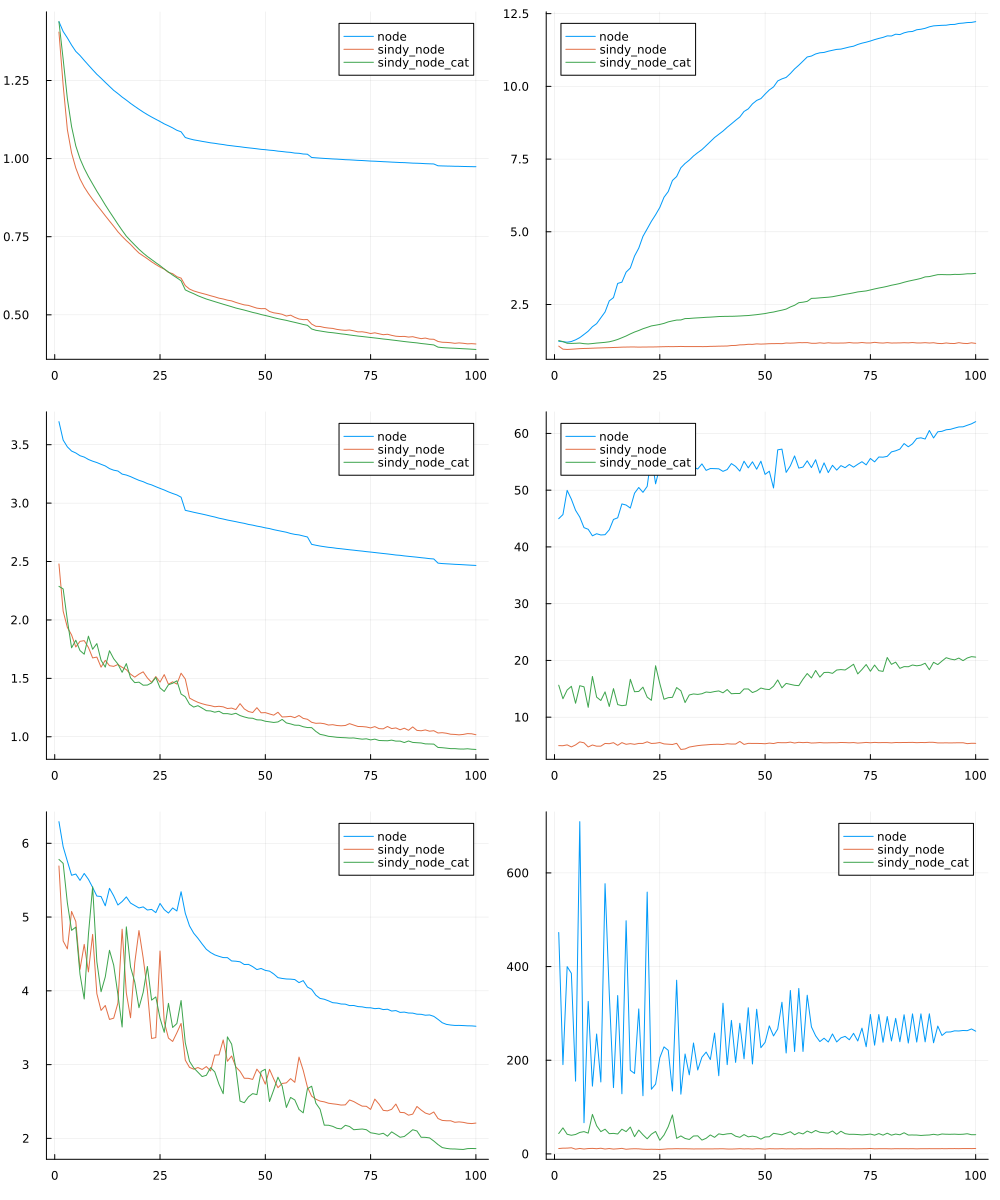

In [15]:
plot1 = plot(readdlm("data/Iteration 01/node_train.csv", ','), label="node")
plot!(readdlm("data/Iteration 01/sindy_node_train.csv", ','), label="sindy_node")
plot!(readdlm("data/Iteration 01/sindy_node_cat_train.csv", ','), label="sindy_node_cat") 

plot2 = plot(readdlm("data/Iteration 01/node_valid.csv", ','), label="node")
plot!(readdlm("data/Iteration 01/sindy_node_valid.csv", ','), label="sindy_node")
plot!(readdlm("data/Iteration 01/sindy_node_cat_valid.csv", ','), label="sindy_node_cat")

plot3 = plot(readdlm("data/Iteration 02/node_train.csv", ','), label="node")
plot!(readdlm("data/Iteration 02/sindy_node_train.csv", ','), label="sindy_node")
plot!(readdlm("data/Iteration 02/sindy_node_cat_train.csv", ','), label="sindy_node_cat")

plot4 = plot(readdlm("data/Iteration 02/node_valid.csv", ','), label="node")
plot!(readdlm("data/Iteration 02/sindy_node_valid.csv", ','), label="sindy_node")
plot!(readdlm("data/Iteration 02/sindy_node_cat_valid.csv", ','), label="sindy_node_cat")

plot5 = plot(readdlm("data/Iteration 03/node_train.csv", ','), label="node")
plot!(readdlm("data/Iteration 03/sindy_node_train.csv", ','), label="sindy_node")
plot!(readdlm("data/Iteration 03/sindy_node_cat_train.csv", ','), label="sindy_node_cat")

plot6 = plot(readdlm("data/Iteration 03/node_valid.csv", ','), label="node")
plot!(readdlm("data/Iteration 03/sindy_node_valid.csv", ','), label="sindy_node")
plot!(readdlm("data/Iteration 03/sindy_node_cat_valid.csv", ','), label="sindy_node_cat")

plot(plot1, plot2, plot3, plot4, plot5, plot6, layout = grid(3, 2), size=(1000,1200))

# Model experimentation

In [4]:
using OrdinaryDiffEq, NODEData

push!(LOAD_PATH, "../../src")

using Pendulum, NeuralODE, SymReg

m1 = 1 #units of kg
m2 = 1 
l1 = 1 #units of m
l2 = 1
g = 10 #units of kg*m/s^2

pendulum = DoublePendulum([m1, m2, l1, l2, g])

x0 = [3.141f0, 3.141f0, 0, 0] 

t_transient = 0f0
N_t = 500
dt = 0.1f0

0.1f0

In [5]:
function build_model(filename)
    p, re_nn = load_ANN(string(filename,".bson"))
    node_fct(u, p, t) = re_nn(p)(u)
    node_prob = ODEProblem(node_fct, x0, (Float32(0.),Float32(dt)), p)

    NODE(node_prob)
end

function build_sindy_model(filename)
    p, re_nn = load_ANN(string(filename,".bson"))
    sindy = load_sindy(string(filename,".ser"))
    if size(re_nn(p)[1].weight)[2] == 4
        node_prob = ODEProblem((u,p,t) -> re_nn(p)(sindy(u)), x0, (Float32(0.),Float32(dt)), p)
        return NODE(node_prob)
    elseif size(re_nn(p)[1].weight)[2] == 8
        node_prob = ODEProblem((u,p,t) -> re_nn(p)(vcat(sindy(u),u)), x0, (Float32(0.),Float32(dt)), p)
        return NODE(node_prob)
    else
        println("Error: Wrong size of NN")
    end 
end

using Statistics

function error(model::NODE, test_data)
    losses = Float32[]

    for (i, data) in enumerate(test_data)
        t, x = data
        result = model((t,x))
        push!(losses, mse(result, x))
    end

    return mean(losses)
end

function error(model::ODEProblem, test_data)
    losses = Float32[]

    for (i, data) in enumerate(test_data)
        t, x = data
        result = Array(solve(remake(model; tspan=(t[1],t[end]),u0=x[:,1]), Tsit5(); saveat=t))
        push!(losses, mse(result, x))
    end

    return mean(losses)
end

function mse(x, x̂)
    return sum(abs2, x .- x̂)/length(x)
end

mse (generic function with 1 method)

In [9]:
node1 = build_model("models/Iteration 01/node")
node2 = build_model("models/Iteration 02/node")
node3 = build_model("models/Iteration 03/node")

sindy_node1 = build_sindy_model("models/Iteration 01/sindy_node")
sindy_node2 = build_sindy_model("models/Iteration 02/sindy_node")
sindy_node3 = build_sindy_model("models/Iteration 03/sindy_node")

sindy_node_cat1 = build_sindy_model("models/Iteration 01/sindy_node_cat")
sindy_node_cat2 = build_sindy_model("models/Iteration 02/sindy_node_cat")
sindy_node_cat3 = build_sindy_model("models/Iteration 03/sindy_node_cat")

sindy = load_sindy("models/Iteration 01/sindy_node.ser")
sindy_prob = ODEProblem((u,p,t) -> sindy(u), x0, (Float32(0.),Float32(dt)))
sindy_cat = load_sindy("models/Iteration 01/sindy_node_cat.ser")
sindy_cat_prob = ODEProblem((u,p,t) -> sindy_cat(u), x0, (Float32(0.),Float32(dt)))

ODEProblem with uType Vector{Float32} and tType Float32. In-place: false
timespan: (0.0f0, 0.1f0)
u0: 4-element Vector{Float32}:
 3.141
 3.141
 0.0
 0.0

In [10]:
using StatsPlots

test_data = generate_train_data(pendulum, 8, x0; N_t, dt, t_transient)

iter1 = [node1, sindy_node1, sindy_node_cat1]
errors1 = [error(model, test_data) for model in iter1]
iter2 = [node2, sindy_node2, sindy_node_cat2]
errors2= [error(model, test_data) for model in iter2]
iter3 = [node3, sindy_node3, sindy_node_cat3]
errors3 = [error(model, test_data) for model in iter3]

3-element Vector{Float32}:
 104.19813
   6.004418
  17.178286

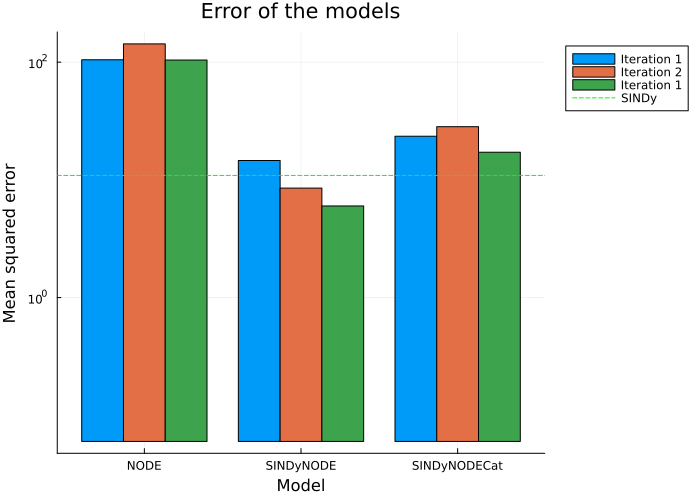

In [12]:
groupedbar([errors1 errors2 errors3], 
    xticks = (1:3, ["NODE", "SINDyNODE", "SINDyNODECat"]),
    ylabel = "Mean squared error",
    xlabel = "Model",
    yscale = :log10,
    title = "Error of the models",
    labels = ["Iteration 1" "Iteration 2"],
    legend = :outertopright, 
    size = (700, 500))
hline!([error(sindy_prob, test_data)], linestyle=:dash, label="SINDy", color="lime")